# GANs

The file is broken up as follows:

  1. [Question 1: Adversarial Examples & GANs](#1)  
  1. [Question 2: A Convolutional Discriminator](#2)  
  1. [Question 3: Mode Collapse](#3)  
  1. [Question 4: Latent Interpolation](#4)  

## Setup

If you do not have access to a CUDA-compatible NVIDIA GPU, it is recommended that you run this notebook in [Google Colab](https://colab.research.google.com/). There, you will have the option to enable GPU acceleration with `Runtime` >> `Change runtime type` >> `Hardware accelerator` >> `GPU` >> `Save`. Note that you may have to re-connect or restart the notebook after changing runtime types.

In [ ]:
# helper code from the course repository
!git clone https://github.com/interactiveaudiolab/course-deep-learning.git
# install common pacakges used for deep learning
!cd course-deep-learning/ && pip install -r requirements.txt

Cloning into 'course-deep-learning'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 575 (delta 15), reused 19 (delta 8), pack-reused 547 (from 1)
Receiving objects: 100% (575/575), 146.09 MiB | 14.63 MiB/s, done.
Resolving deltas: 100% (303/303), done.
Updating files: 100% (63/63), done.


In [ ]:
%matplotlib inline
%cd course-deep-learning/

import datetime
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm

from utils.gan import *
from utils.adversarial_examples import *

/content/course-deep-learning/course-deep-learning


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = "course-deep-learning.zip"  # Change to your actual file name
extract_path = "extracted_folder"  # Destination folder

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)  # Check extracted files

['__MACOSX', 'course-deep-learning']

----
## <a name="1">Question 1: Adversarial Examples & GANs (four points total)</a>

In [notebook 5](https://github.com/interactiveaudiolab/course-deep-learning/blob/main/notebooks/notebook_5_adversarial_examples.ipynb), we learned how to generate _adversarial examples_ by optimizing images so that they would be recognized in a certain way by a neural network. Often, we did so by applying very small _perturbations_, and the resulting adversarial examples looked similar to the original unperturbed images. This begs the question: if we allowed for very large perturbations, would our adversarial examples start to resemble images of our chosen class?

### __1.1__: Generating Adversarial Examples (one point)

First, we'll review the process of generating adversarial examples. __Modify the code below to craft an adversarial examples that is as _imperceptible_ as possible while still fooling the given neural network into recognizing the digit 9. Include an image of your final adversarial example using the `plot_mnist()` function provided. Then, briefly explain your modifications below.__ Some modifications to consider (these are hints on what to do, not questions to be answered):
* How many iterations will you optimize for?
* Can you use a learning rate to scale your gradient-based updates of the input image?
* Can you somehow "bound" your adversarial perturbation at each iteration?

Feel free to look at  [notebook 5](https://github.com/interactiveaudiolab/course-deep-learning/blob/main/notebooks/notebook_5_adversarial_examples.ipynb) for ideas.

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR IMAGE HERE)</div>
</center>

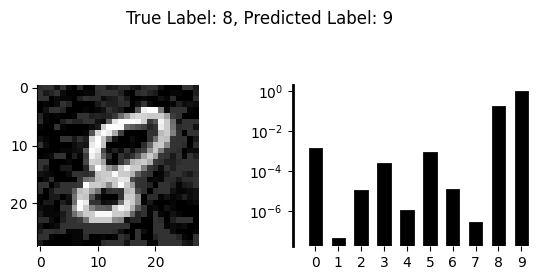

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR EXPLANATION HERE)</div>
</center>

* Our objective is to maximize the probability of the model predicting 9. I use a negative log-likelihood loss, $\mathcal{L}=-\log P(y=9 \mid x+\delta)$, which, in this case, means we want to maximize the probability of being classified as 9. Since $-\log P(y=9)$ is low when the probability of the class is high, we aim to minimize the loss.
* We optimize for 100 iterations.
* We use a learning rate (step size) of 0.1 to control how much we update the input at each step
* We bound the perturbation using delta.clip_(-0.4, 0.4). This ensures that delta stays within a bounded range.


#### Starter Code

Modify this code where indicated to craft your adversarial example.

<ipython-input-35-e50c41c46ac0>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./utils/adversarial_examples/pretrained/mnist_classifier.

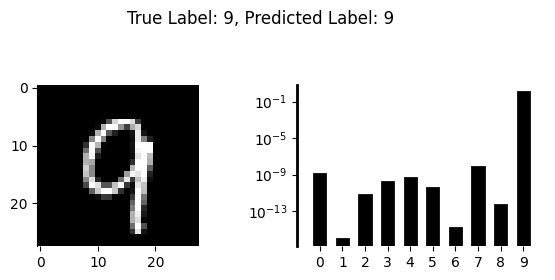

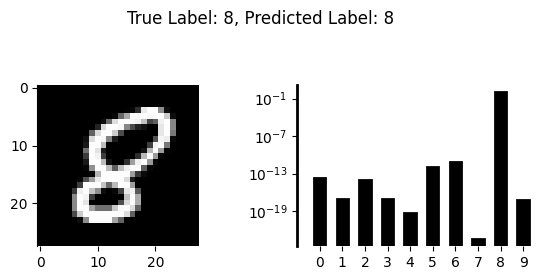

Iteration: 0; Prediction: 8
Iteration: 10; Prediction: 9
Iteration: 20; Prediction: 8
Iteration: 30; Prediction: 8
Iteration: 40; Prediction: 8
Iteration: 50; Prediction: 9
Iteration: 60; Prediction: 8
Iteration: 70; Prediction: 8
Iteration: 80; Prediction: 8
Iteration: 90; Prediction: 9


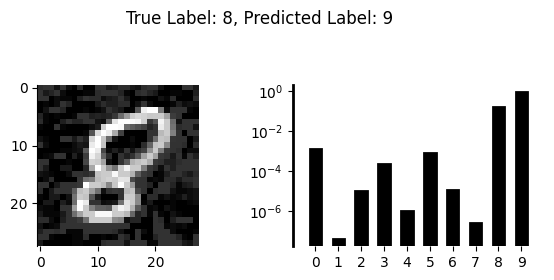

In [ ]:
# fix random seed - this makes sure we don't accidentally grab an input
# from the class we are trying to 'impersonate'
torch.manual_seed(0)

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# download MNIST data
mnist_train, mnist_test = load_mnist()

# load neural network classifier
model = MNISTClassifier()
model.to(device)

# load pretrained weights (included with repo)
model.load_state_dict(torch.load('./utils/adversarial_examples/pretrained/mnist_classifier.pt', map_location=device))

# select an input
batch_x, batch_y = next(iter(mnist_test))
x, y = batch_x[0].to(device), batch_y[0].to(device)

# plot original image and the model's prediction (class scores) side-by-side
plot_mnist(x, y, model)

# we want the network to predict the label '9' given our adversarial input, so
# we'll set this as our 'target' when computing our loss and optimizing
target = torch.tensor([9]).to(device)

# our input image; make sure we tell PyTorch to track its gradients
x = x.reshape(1, 1, 28, 28).detach()

# iteratively optimize an additive perturbation to our input
delta = torch.zeros_like(x, requires_grad=True) 


################################################################################
# YOUR MODIFICATIONS CAN START HERE
################################################################################

# learning rate for updates
step_size = 0.1  # Small step for gradual change
n_iter = 100  # Enough iterations to fool the network
epsilon = 0.4  # Bound perturbation magnitude

# Select an image that is NOT already a "9"
while True:
    batch_x, batch_y = next(iter(mnist_test))
    x, y = batch_x[0].to(device), batch_y[0].to(device)
    if y.item() != 9:  # Ensure we start with a non-9 image
        break

# Plot original image and its prediction
plot_mnist(x, y, model)

# Target label (9)
target = torch.tensor([9]).to(device)

# Initialize perturbation
x = x.reshape(1, 1, 28, 28)  # Ensure correct shape
delta = torch.zeros_like(x).requires_grad_(True) # Track gradients Loss wrt delta

# perturbation "training" loop
for i in range(n_iter):

    if delta.grad is not None:
        delta.grad.zero_()

    # Compute model's prediction given perturbed input
    outputs = model(x + delta)

    # Log current prediction
    if i % 10 == 0:
        print(f"Iteration: {i}; Prediction: {outputs.argmax().item()}")

    # Compute loss (maximize probability of 9)
    loss = torch.nn.functional.nll_loss(outputs, target)  # Negative log-likelihood loss

    # Compute gradient
    loss.backward()
    grad = delta.grad.detach()

    # Update perturbation
    with torch.no_grad():
        delta -= torch.sign(grad) * step_size # we want to minimize the loss
        delta.clip_(min=-epsilon, max=epsilon)  # Bound perturbation

# Plot adversarial example and its prediction
plot_mnist(x + delta.detach(), y, model) # Detach delta to avoid tracking gradients

### __1.2__: Unbounded Adversarial Examples (one point)

Next, we'll remove our "imperceptibility" constraint and try to craft an adversarial perturbation _so large that the perturbed image looks to a human like an instance of the target class_. That is, we'll try to optimize an image of one class to look like an image from another class. __Modify the starter code above to craft a _large_ adversarial perturbation that makes the classifier _as confident as possible_ that it is seeing the target class (9). Include an image of your final adversarial example below.__

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR IMAGE HERE)</div>
</center>

***original example***

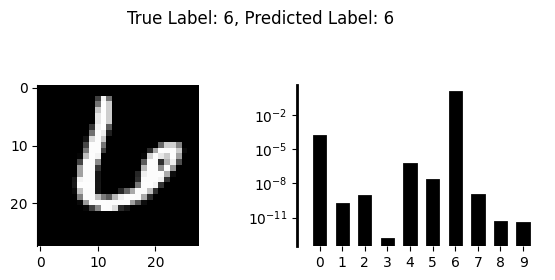

***my final adversarial example***

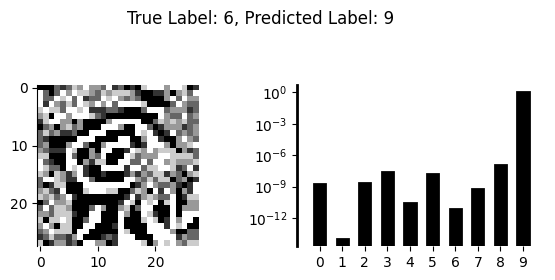

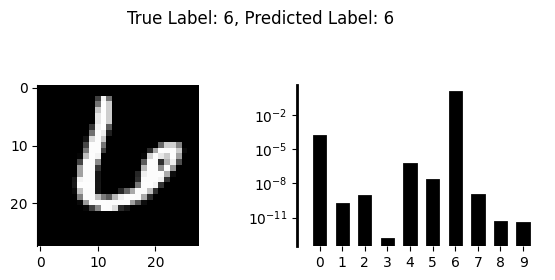

Iteration: 0; Prediction: 6
Iteration: 50; Prediction: 9
Iteration: 100; Prediction: 9
Iteration: 150; Prediction: 9
Iteration: 200; Prediction: 9
Iteration: 250; Prediction: 9
Iteration: 300; Prediction: 9
Iteration: 350; Prediction: 9
Iteration: 400; Prediction: 9
Iteration: 450; Prediction: 9


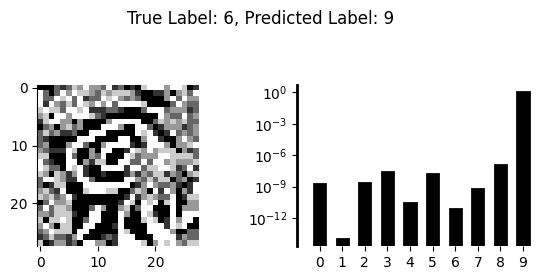

In [ ]:
################################################################################
# YOUR MODIFICATIONS CAN START HERE
################################################################################

# Learning rate (step size) for updates
step_size = 0.2  # Larger step size for aggressive transformation
n_iter = 500  # More iterations to fully transform the image

# Select an image that is NOT already a "9"
while True:
    batch_x, batch_y = next(iter(mnist_test))
    x, y = batch_x[0].to(device), batch_y[0].to(device)
    if y.item() != 9:  # Ensure we start with a non-9 image
        break

# Plot original image and its prediction
plot_mnist(x, y, model)

# Target label (9)
target = torch.tensor([9]).to(device)

# Initialize the image as a variable (instead of perturbation-based changes)
x.requires_grad = True  # Directly optimize input pixels

# Adversarial transformation loop
for i in range(n_iter):

    if x.grad is not None:
        x.grad.zero_()

    # Compute model's prediction given modified input (Ensure correct shape)
    outputs = model(x.view(1, 1, 28, 28))

    # Log current prediction
    if i % 50 == 0:
        print(f"Iteration: {i}; Prediction: {outputs.argmax().item()}")

    # Compute loss: Force model to classify as "9"
    loss = - outputs[0, 9]

    # Compute gradient
    loss.backward()

    # Ensure gradient is not None before updating
    if x.grad is None:
        raise RuntimeError("Gradient is None. Check requires_grad settings.")

    grad = x.grad.detach()

    # Update image directly (No in-place operation)
    with torch.no_grad():
        x = x - step_size * grad.sign()  # Fix: Avoid in-place ops
        x = torch.clamp(x, 0, 1)  # Keep pixel values in valid range (0-1)

    # Re-enable requires_grad for x after each update
    x.requires_grad_()

# Plot final transformed image and its prediction
plot_mnist(x.detach().view(1, 1, 28, 28), y, model)


### __1.3__: Free Response (two points)

A young researcher is studying adversarial examples and GANs, and notes that both topics involve using the gradients of a neural network to craft inputs that the network classifies in a certain way. The researcher therefore posits that a simple alternative to GANs would be to first train a classifier to recognize images of the classes one wants to generate (e.g. handwritten digits), and then to optimize a random noise image just like an adversarial example until the classifier recognizes it as the desired class. __Is it likely this approach will yield images that look like clear examples of the desired class? Why or why not? Support your answer with  results. You should do something like question 1.2 above, but try it repeatedly (maybe 10 or more times), each time from a different image comprised of random noise.__

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR ANSWER HERE)</div>
</center>

- From the results, I have to say that some do look like the digit 9, although some are definitely harder to identify.  
- The reason it’s failing is probably that there is no initial structure when starting from random noise.  
- ***Why might starting from an existing digit be better?*** This could be because there is already some structure in place, so the optimizer only needs to make small adjustments to transform it into a 9.  
- Additionally, some digits share a similar structure with 9. For example, the curve of a 6 can be modified slightly to resemble a 9.  

Experiment 1/10


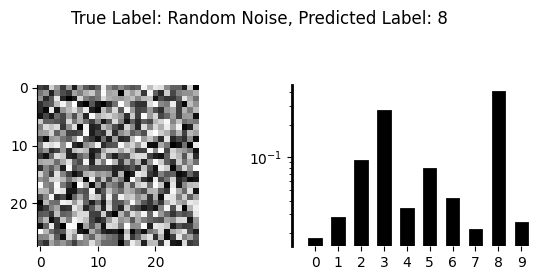

Iteration: 0; Prediction: 8, P(9)=0.041693
Iteration: 100; Prediction: 9, P(9)=0.998967
Iteration: 200; Prediction: 9, P(9)=0.895453
Iteration: 300; Prediction: 9, P(9)=0.996377
Iteration: 400; Prediction: 9, P(9)=0.999925
Iteration: 500; Prediction: 9, P(9)=0.999276
Iteration: 600; Prediction: 9, P(9)=0.999665
Iteration: 700; Prediction: 9, P(9)=0.999746
Iteration: 800; Prediction: 9, P(9)=0.999987
Iteration: 900; Prediction: 9, P(9)=0.999989


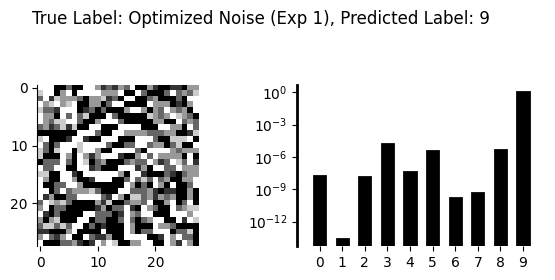

Experiment 2/10


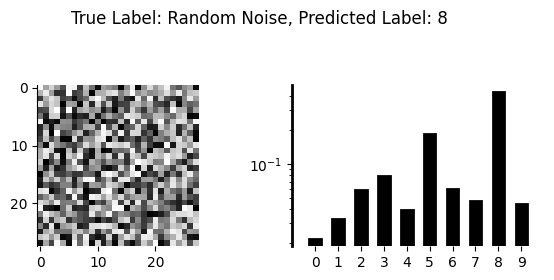

Iteration: 0; Prediction: 8, P(9)=0.052157
Iteration: 100; Prediction: 9, P(9)=0.971462
Iteration: 200; Prediction: 9, P(9)=0.999778
Iteration: 300; Prediction: 9, P(9)=0.986638
Iteration: 400; Prediction: 9, P(9)=0.985710
Iteration: 500; Prediction: 9, P(9)=0.999851
Iteration: 600; Prediction: 9, P(9)=0.993533
Iteration: 700; Prediction: 9, P(9)=0.999204
Iteration: 800; Prediction: 9, P(9)=0.991436
Iteration: 900; Prediction: 9, P(9)=0.999017


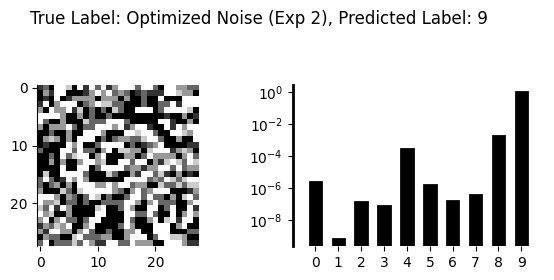

Experiment 3/10


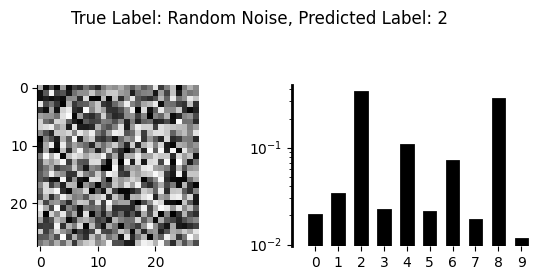

Iteration: 0; Prediction: 8, P(9)=0.021313
Iteration: 100; Prediction: 9, P(9)=0.997647
Iteration: 200; Prediction: 9, P(9)=0.999715
Iteration: 300; Prediction: 9, P(9)=0.999024
Iteration: 400; Prediction: 9, P(9)=0.999861
Iteration: 500; Prediction: 9, P(9)=0.999681
Iteration: 600; Prediction: 9, P(9)=0.999914
Iteration: 700; Prediction: 9, P(9)=0.989668
Iteration: 800; Prediction: 9, P(9)=0.999692
Iteration: 900; Prediction: 9, P(9)=0.999666


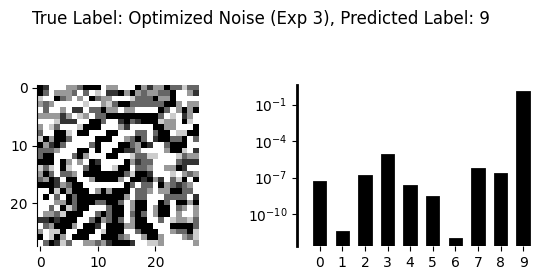

Experiment 4/10


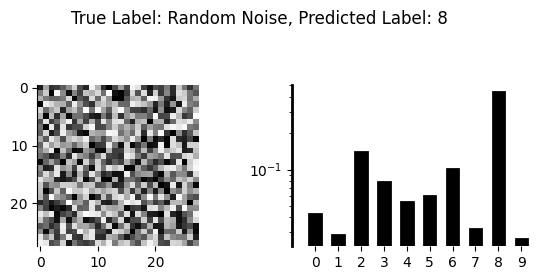

Iteration: 0; Prediction: 8, P(9)=0.025632
Iteration: 100; Prediction: 9, P(9)=1.000000
Iteration: 200; Prediction: 9, P(9)=0.999970
Iteration: 300; Prediction: 9, P(9)=0.989713
Iteration: 400; Prediction: 9, P(9)=0.995814
Iteration: 500; Prediction: 9, P(9)=0.984017
Iteration: 600; Prediction: 9, P(9)=0.999985
Iteration: 700; Prediction: 9, P(9)=0.998618
Iteration: 800; Prediction: 9, P(9)=0.999661
Iteration: 900; Prediction: 9, P(9)=1.000000


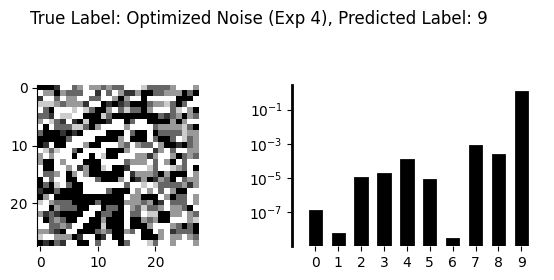

Experiment 5/10


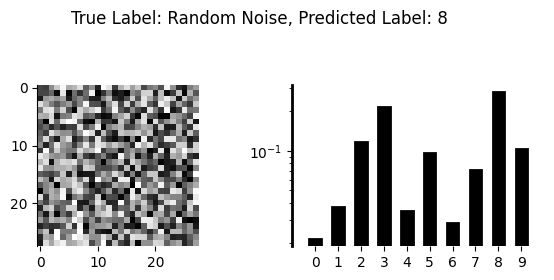

Iteration: 0; Prediction: 3, P(9)=0.099090
Iteration: 100; Prediction: 9, P(9)=0.998921
Iteration: 200; Prediction: 9, P(9)=0.998830
Iteration: 300; Prediction: 9, P(9)=0.999766
Iteration: 400; Prediction: 9, P(9)=0.999862
Iteration: 500; Prediction: 9, P(9)=0.999766
Iteration: 600; Prediction: 9, P(9)=0.998042
Iteration: 700; Prediction: 9, P(9)=0.999999
Iteration: 800; Prediction: 9, P(9)=0.999985
Iteration: 900; Prediction: 9, P(9)=0.993755


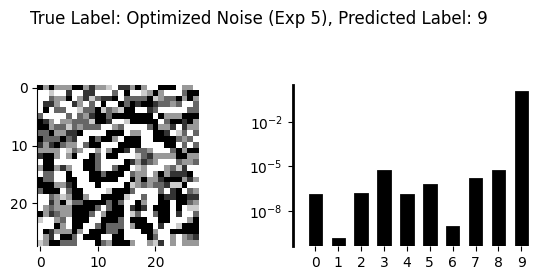

Experiment 6/10


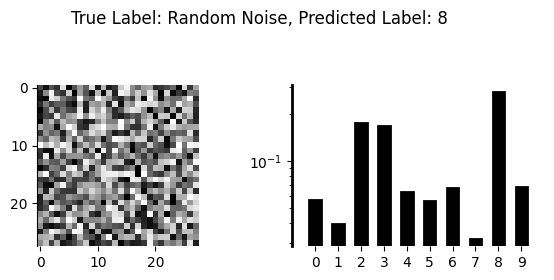

Iteration: 0; Prediction: 8, P(9)=0.093938
Iteration: 100; Prediction: 9, P(9)=0.999898
Iteration: 200; Prediction: 9, P(9)=0.999821
Iteration: 300; Prediction: 9, P(9)=0.997750
Iteration: 400; Prediction: 9, P(9)=0.999971
Iteration: 500; Prediction: 9, P(9)=0.999783
Iteration: 600; Prediction: 9, P(9)=0.999857
Iteration: 700; Prediction: 9, P(9)=0.998762
Iteration: 800; Prediction: 9, P(9)=0.999987
Iteration: 900; Prediction: 9, P(9)=0.999680


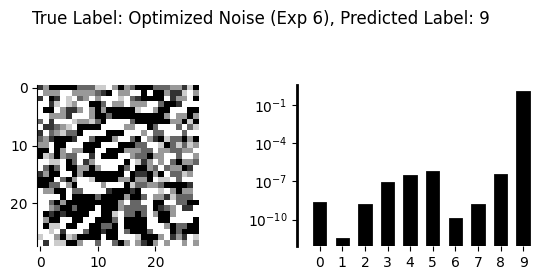

Experiment 7/10


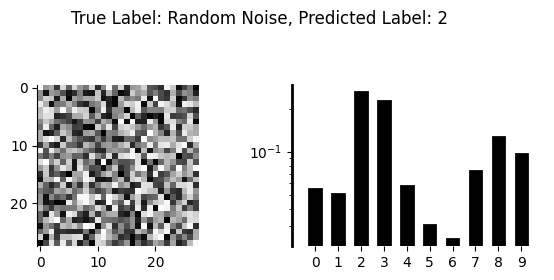

Iteration: 0; Prediction: 2, P(9)=0.055063
Iteration: 100; Prediction: 9, P(9)=0.985124
Iteration: 200; Prediction: 9, P(9)=0.999889
Iteration: 300; Prediction: 9, P(9)=0.999184
Iteration: 400; Prediction: 9, P(9)=0.999559
Iteration: 500; Prediction: 9, P(9)=0.999618
Iteration: 600; Prediction: 9, P(9)=0.999734
Iteration: 700; Prediction: 9, P(9)=0.999992
Iteration: 800; Prediction: 9, P(9)=0.999997
Iteration: 900; Prediction: 9, P(9)=1.000000


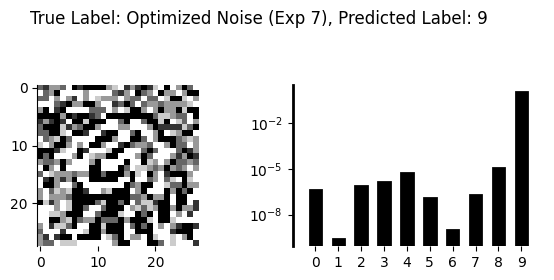

Experiment 8/10


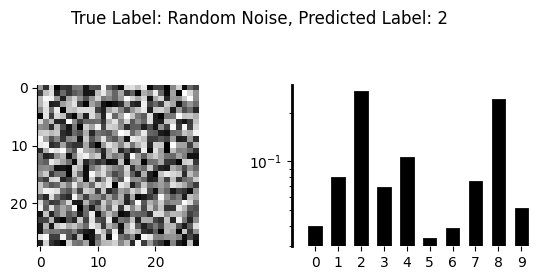

Iteration: 0; Prediction: 8, P(9)=0.091151
Iteration: 100; Prediction: 9, P(9)=0.999331
Iteration: 200; Prediction: 9, P(9)=0.999680
Iteration: 300; Prediction: 9, P(9)=0.999999
Iteration: 400; Prediction: 9, P(9)=0.999984
Iteration: 500; Prediction: 9, P(9)=0.999785
Iteration: 600; Prediction: 9, P(9)=0.999959
Iteration: 700; Prediction: 9, P(9)=0.999998
Iteration: 800; Prediction: 9, P(9)=0.998846
Iteration: 900; Prediction: 9, P(9)=0.999994


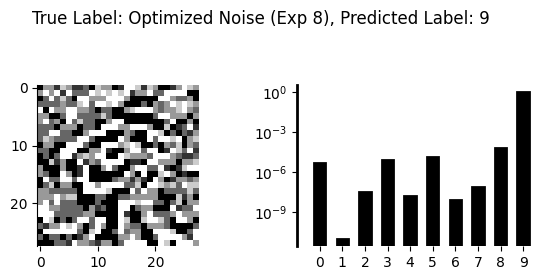

Experiment 9/10


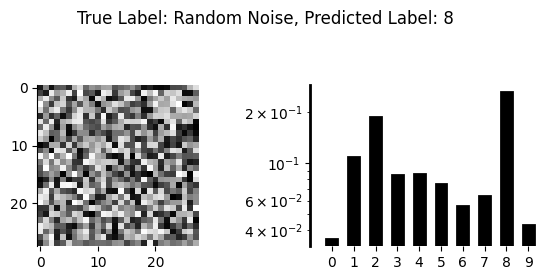

Iteration: 0; Prediction: 8, P(9)=0.049823
Iteration: 100; Prediction: 9, P(9)=0.999999
Iteration: 200; Prediction: 9, P(9)=0.999951
Iteration: 300; Prediction: 9, P(9)=0.999990
Iteration: 400; Prediction: 9, P(9)=0.997817
Iteration: 500; Prediction: 9, P(9)=0.999937
Iteration: 600; Prediction: 9, P(9)=0.999987
Iteration: 700; Prediction: 9, P(9)=0.998442
Iteration: 800; Prediction: 9, P(9)=0.999650
Iteration: 900; Prediction: 9, P(9)=0.996610


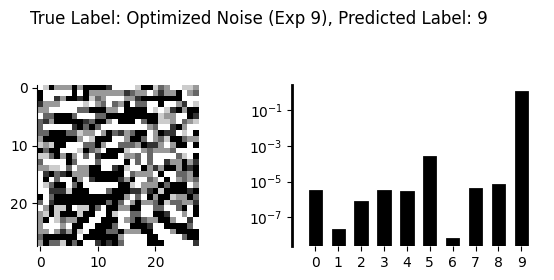

Experiment 10/10


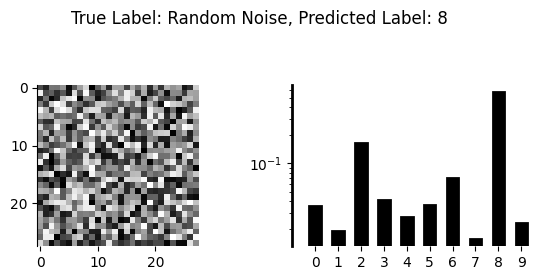

Iteration: 0; Prediction: 8, P(9)=0.038225
Iteration: 100; Prediction: 9, P(9)=0.999189
Iteration: 200; Prediction: 9, P(9)=0.999757
Iteration: 300; Prediction: 9, P(9)=0.999896
Iteration: 400; Prediction: 9, P(9)=0.999962
Iteration: 500; Prediction: 9, P(9)=0.999785
Iteration: 600; Prediction: 9, P(9)=0.999950
Iteration: 700; Prediction: 9, P(9)=0.999872
Iteration: 800; Prediction: 9, P(9)=0.999805
Iteration: 900; Prediction: 9, P(9)=0.999969


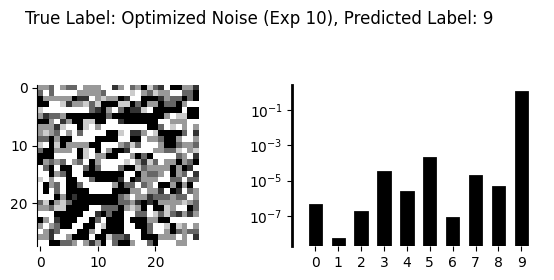

In [ ]:
################################################################################
# EXPERIMENT: Can optimizing noise make realistic digits?
################################################################################

# Learning rate (step size) for updates
step_size = 0.4
n_iter = 1000
num_experiments = 10

for exp in range(num_experiments):
    print(f"Experiment {exp + 1}/{num_experiments}")

    # Start from random noise instead of a digit
    x = torch.rand(1, 1, 28, 28).to(device)  # Random uniform noise
    x.requires_grad = True  # Enable gradient tracking

    # Plot original random noise image
    plot_mnist(x, "Random Noise", model)

    # Target label (9)
    target = torch.tensor([9]).to(device)

    # Adversarial transformation loop
    for i in range(n_iter):

        if x.grad is not None:
            x.grad.zero_()

        # Compute model's prediction given modified input
        outputs = model(x)

        # Log current prediction
        if i % 100 == 0:
            prob_9 = torch.softmax(outputs, dim=1)[0, 9].item()
            print(f"Iteration: {i}; Prediction: {outputs.argmax().item()}, P(9)={prob_9:.6f}")

        # loss: Force model to classify as "9"
        loss = -outputs[0, 9]

        # Compute gradient
        loss.backward()

        # Ensure gradient is not None before updating
        if x.grad is None:
            raise RuntimeError("Gradient is None. Check requires_grad settings.")

        grad = x.grad.detach()

        # Use gradient updates to morph noise toward "9"
        with torch.no_grad():
            x = x - step_size * grad.sign()  # Move toward "9"
            x = torch.clamp(x, 0, 1)  # Keep pixel values valid

        # Re-enable requires_grad for x after each update
        x.requires_grad_()

    # Plot final transformed image and its prediction
    plot_mnist(x.detach(), f"Optimized Noise (Exp {exp + 1})", model)


----
## <a name="2">Question 2: A Convolutional Discriminator (three points total)</a>

We've previously seen how convolutional neural networks can outperform their fully-connected counterparts by leveraging the local spatial structure inerent to image data. This begs the question: could we strenghten our GAN by using convolutions? We'll put this hypothesis to the test with a new dataset, [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist), that consists of articles of clothing rather than handwritten digits. We'll start by looking at some of the convolutional arithmetic that motivates the design of our discriminator.

### 2.1: Building a Convolutional Discriminator (one point)

We will structure our discriminator as a sequence of four convolutional layers, using the `torch.nn.Conv2d` module. Each convolutional layer will take a tensor of shape `(batch_size, in_channels, in_height, in_width)` and output a tensor of shape `(batch_size, out_channels, out_height, out_width)`. The first three layers will progressively _downsample_ along the spatial dimensions (height and width) while _upsampling_ along the channel dimension, thereby aggregating spatial features from across the entire image. Our fourth layer will then map this learned representation to a scalar probability that the input image is real (i.e. comes from the dataset and not the generator).

__Complete the `DCDiscriminator` definition in the code below. The expected dimensions of each layer's input and output have been provided in comments; your job is to fill in the missing parameter values.__

In [ ]:
class DCDiscriminator(torch.nn.Module):

    def __init__(self, hidden_size: int = 32):
        """
        Given images with spatial dimensions (1, 28, 28), produce a scalar
        probability that each image is real: (n_batch, 1, 28, 28) --> (n_batch, 1)
        """

        super().__init__()

        self.net = torch.nn.Sequential(

            ####################################################################
            # YOUR CODE STARTS HERE
            ####################################################################

            # input shape: (n_batch, 1, 28, 28)

            torch.nn.Conv2d(
                in_channels=1,
                out_channels=hidden_size,
                kernel_size=4, ### FILL ME IN ###
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.LeakyReLU(0.2, inplace=True),

            # intermediate shape: (n_batch, hidden_size, 14, 14)

            torch.nn.Conv2d(
                in_channels=hidden_size,
                out_channels=hidden_size * 2,
                kernel_size=4,
                stride=2,  ### FILL ME IN ###
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(hidden_size * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),

            # intermediate shape: (n_batch, hidden_size*2, 7, 7)

            torch.nn.Conv2d(
                in_channels=hidden_size * 2,
                out_channels=hidden_size * 4,
                kernel_size=4,
                stride=2,
                padding=1, ### FILL ME IN ###
                bias=False
            ),
            torch.nn.BatchNorm2d(hidden_size * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),

            # intermediate shape: (n_batch, hidden_size*4, 3, 3)

            torch.nn.Conv2d(
                in_channels=hidden_size * 4,
                out_channels=1,
                kernel_size=3, ### FILL ME IN ###
                stride=1,
                padding=0,
                bias=False
            ),
            torch.nn.Sigmoid()

            # final shape: (n_batch, 1, 1, 1)

            ####################################################################
            # YOUR CODE ENDS HERE
            ####################################################################

        )

        # weight initialization - don't worry about this
        for m in self.modules():

            name = m.__class__.__name__

            if name.find('Conv') != -1:
                nn.init.normal_(m.weight.data, 0.0, 0.02)

            elif name.find('BatchNorm') != -1:
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0)


    def forward(self, x: torch.Tensor):

        assert x.ndim >=2
        n_batch = x.shape[0]

        return self.net(x).reshape(n_batch, 1)

You can test your solution with the code below:

In [ ]:
# run this code to test your convolution layers' input and output shapes
test_net = DCDiscriminator(hidden_size=32).net
test_input = torch.randn(10, 1, 28, 28)

# check first conv layer
test_input = test_net[0](test_input)
assert tuple(test_input.shape) == (10, 32, 14, 14), f'Incorrect output shape {test_input.shape} from first convolutional layer'

# check second conv layer
test_input = test_net[2](test_input)
assert tuple(test_input.shape) == (10, 64, 7, 7), f'Incorrect output shape {test_input.shape} from second convolutional layer'

# check third conv layer
test_input = test_net[5](test_input)
assert tuple(test_input.shape) == (10, 128, 3, 3), f'Incorrect output shape {test_input.shape} from third convolutional layer'

# check fourth conv layer
test_input = test_net[8](test_input)
assert tuple(test_input.shape) == (10, 1, 1, 1), f'Incorrect output shape {test_input.shape} from fourth convolutional layer'

### 2.2: Comparing MLP and Convolutional Discriminators (two points)

Finally, it's time to put our convolutional discriminator to the test. Provided below are definitions for two models: `MLPGAN`, which uses MLP-based generator and discriminator networks, and `NEWGAN`, which uses the convolutional discriminator defined above. __Train both models for 80 epochs on the FashionMNIST dataset. You may use [notebook 6](https://interactiveaudiolab.github.io/course-deep-learning/notebooks/notebook_6_gan.ipynb) as a reference. For each model, provide the following:__
* __A plot of the discriminator scores for real and synthetic inputs, where the Y-axis is the average score per epoch and the X-axis is epochs__
* __An image of a batch of example generations from the fully-trained model__

It is _strongly_ recommended that you train using a GPU (e.g. in Google Colab) to save time.

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR DISCRIMINATOR SCORES PLOTS HERE)</div>
</center>

***MLPGAN***

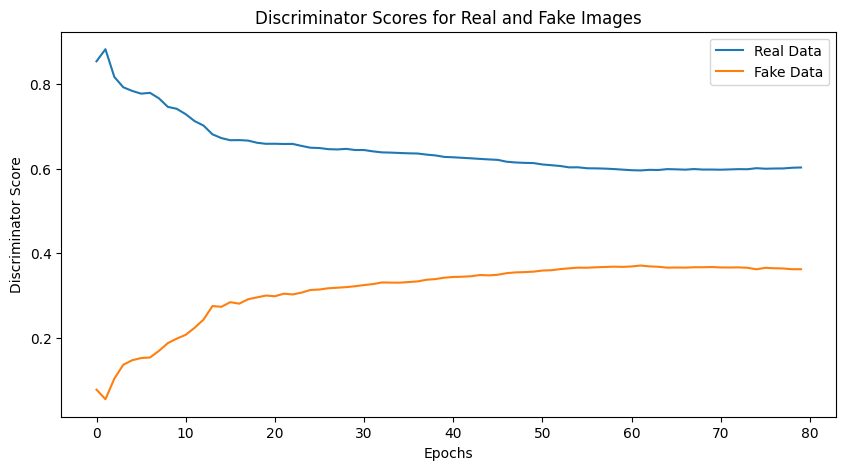

***NEWGAN***

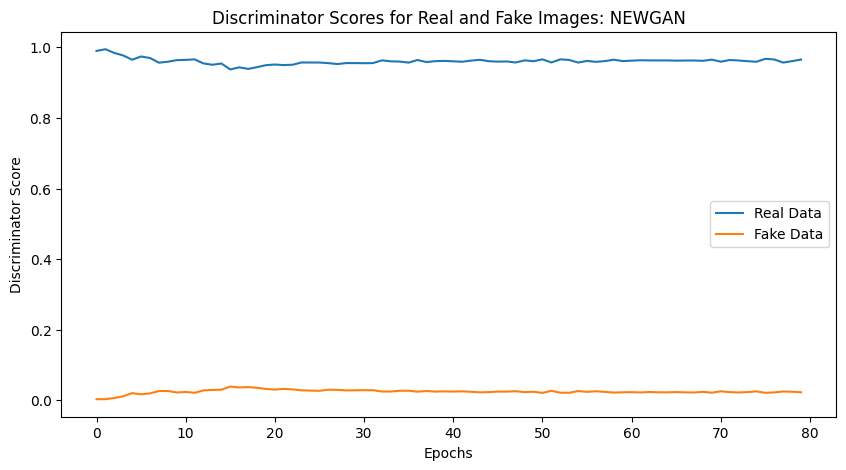


<center>
<div style="color:red;background-color:#e5e5e5">(YOUR EXAMPLE GENERATION IMAGES HERE)</div>
</center>

***MLPGAN***

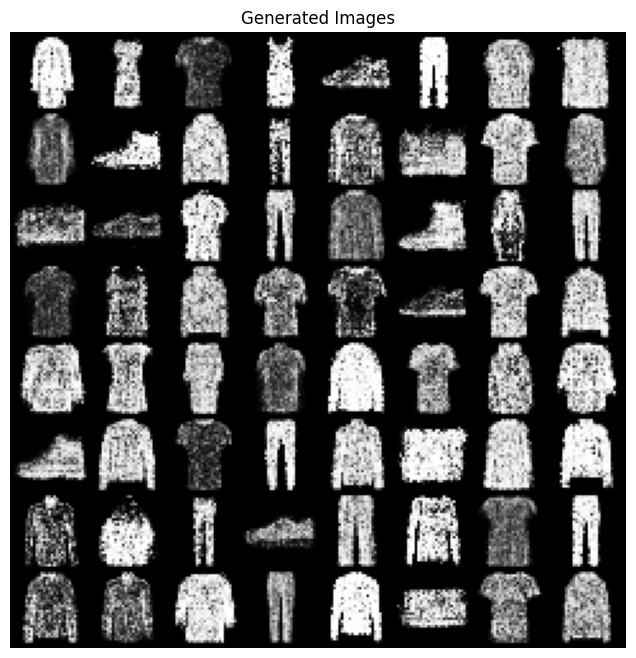

***NEWGAN***

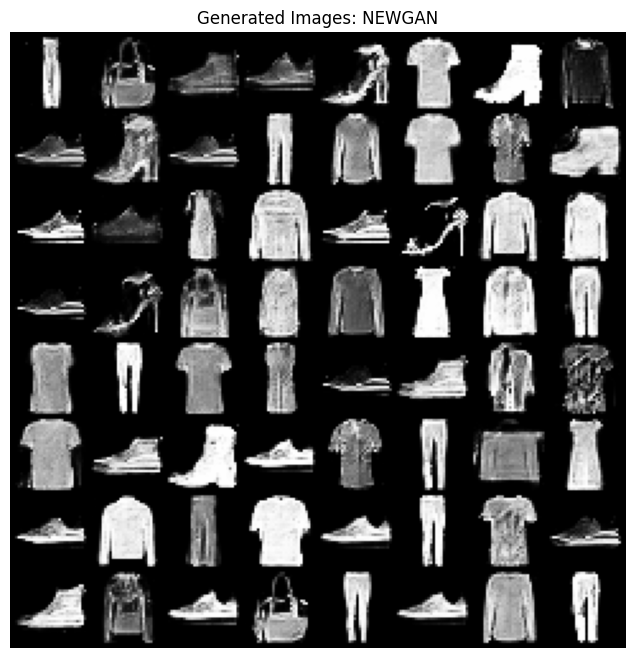

***Some Explanation***

* Embarrassingly, NEWGAN performs very poorly in my case, as seen in the Discriminator Scores for Real and Fake Images.  
* The generated images looked fine to me. One possible reason could be that the discriminator suddenly became much stronger than the generator, causing the generator to give up... 
* We will probably need to strengthen the generator or weaken the discriminator.

#### Model Definitions
Use these model definitions. __Do not edit this cell for this question. You will first need to run the code cell above containing your answer to question 2.2.__

In [14]:
class MLPGenerator(torch.nn.Module):

    def __init__(self, latent_size: int = 64):
        """Construct a simple MLP generator"""

        super().__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(latent_size, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 784),
            torch.nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor):

        # reshape generated images to (n_batch, channels, height, width)
        n_batch = x.shape[0]
        return self.net(x).reshape(n_batch, 1, 28, 28)


class MLPDiscriminator(torch.nn.Module):

    def __init__(self):
        """Construct a simple MLP discriminator"""

        super().__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(784, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor):

        # flatten input images
        n_batch = x.shape[0]
        x = x.reshape(n_batch, -1)

        return self.net(x)


class MLPGAN(torch.nn.Module):

    def __init__(self, latent_size: int = 64):
        """Construct a simple MLP generative adversarial network"""

        super().__init__()

        self.generator = MLPGenerator(latent_size)
        self.discriminator = MLPDiscriminator()


class NEWGAN(torch.nn.Module):

    def __init__(self, latent_size: int = 64):
        """Construct a generative adversarial network with convolutional discriminator and MLP generator"""

        super().__init__()

        self.generator = MLPGenerator(latent_size)
        self.discriminator = DCDiscriminator()  # this is the discriminator you defined above as part of question 2.2!

#### Training Configuration
Use these training hyperparameters. __Do not edit this cell.__

In [15]:
# GAN training hyperparameters
batch_size = 64
latent_size = 64
lr = 0.0002
epochs = 80

# fix random seed
torch.manual_seed(0)

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load FashionMNIST dataset
data = load_fashionmnist(batch_size=batch_size)

# loss function: binary cross-entropy loss
loss = torch.nn.BCELoss()

# determine which labels will correspond to "real" and "fake" predictions from the discriminator
label_real = 1.0
label_fake = 0.0

# select a fixed set of latent vectors z that we will use to visualize the GAN's generation quality each epoch
fixed_latents = torch.randn((batch_size, latent_size)).to(device)

#### Training Loop
__Place your training code in the following cell.__

In [ ]:

# initialize the model
gan = MLPGAN().to(device)
# gan = NEWGAN().to(device)

# use an optimizer to handle parameter updates
opt_discriminator = torch.optim.Adam(gan.discriminator.parameters(), lr=lr)
opt_generator = torch.optim.Adam(gan.generator.parameters(), lr=lr)

################################################################################
# ...YOUR TRAINING CODE HERE for the MLP GAN...
################################################################################


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

# Initialize the model (Change between MLPGAN() and NEWGAN() to test both)
gan = MLPGAN(latent_size).to(device)
# gan = NEWGAN(latent_size).to(device)

# Initialize optimizers
opt_discriminator = optim.Adam(gan.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_generator = optim.Adam(gan.generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Lists to track discriminator scores
disc_real_scores = []
disc_fake_scores = []

# Training loop
for epoch in range(epochs):
    real_score_avg = 0
    fake_score_avg = 0
    num_batches = 0

    for real_images, _ in data:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Generate fake images
        noise = torch.randn(batch_size, latent_size, device=device)
        fake_images = gan.generator(noise)

        # Labels for real and fake images
        labels_real = torch.full((batch_size, 1), label_real, device=device)
        labels_fake = torch.full((batch_size, 1), label_fake, device=device)

        # Train Discriminator
        opt_discriminator.zero_grad()
        real_preds = gan.discriminator(real_images)
        real_loss = loss(real_preds, labels_real)

        fake_preds = gan.discriminator(fake_images.detach())  # Detach to avoid generator updates
        fake_loss = loss(fake_preds, labels_fake)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        opt_discriminator.step()

        # Train Generator
        opt_generator.zero_grad()
        fake_preds = gan.discriminator(fake_images)  # Recalculate since weights changed
        g_loss = loss(fake_preds, labels_real)  # Want fake to be classified as real
        g_loss.backward()
        opt_generator.step()

        # Store average discriminator scores for tracking
        real_score_avg += real_preds.mean().item()
        fake_score_avg += fake_preds.mean().item()
        num_batches += 1

    disc_real_scores.append(real_score_avg / num_batches)
    disc_fake_scores.append(fake_score_avg / num_batches)

    print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# Store results
torch.save(gan.state_dict(), "gan_trained.pth")


Epoch 1/80 - D Loss: 0.3165, G Loss: 7.0601
Epoch 2/80 - D Loss: 0.2240, G Loss: 2.6542
Epoch 3/80 - D Loss: 1.3245, G Loss: 4.5903
Epoch 4/80 - D Loss: 0.8002, G Loss: 1.9070
Epoch 5/80 - D Loss: 0.4459, G Loss: 1.9247
Epoch 6/80 - D Loss: 0.8780, G Loss: 3.5274
Epoch 7/80 - D Loss: 0.6859, G Loss: 3.4483
Epoch 8/80 - D Loss: 0.6419, G Loss: 1.5846
Epoch 9/80 - D Loss: 0.6417, G Loss: 1.5722
Epoch 10/80 - D Loss: 0.3462, G Loss: 2.6205
Epoch 11/80 - D Loss: 0.9349, G Loss: 1.3184
Epoch 12/80 - D Loss: 0.7544, G Loss: 2.2129
Epoch 13/80 - D Loss: 1.0424, G Loss: 0.9072
Epoch 14/80 - D Loss: 0.9264, G Loss: 1.5464
Epoch 15/80 - D Loss: 0.8204, G Loss: 1.4937
Epoch 16/80 - D Loss: 1.2239, G Loss: 0.9114
Epoch 17/80 - D Loss: 0.9728, G Loss: 1.3285
Epoch 18/80 - D Loss: 1.0073, G Loss: 1.6005
Epoch 19/80 - D Loss: 0.9200, G Loss: 1.3531
Epoch 20/80 - D Loss: 0.9835, G Loss: 1.0928
Epoch 21/80 - D Loss: 0.9957, G Loss: 1.1631
Epoch 22/80 - D Loss: 0.9075, G Loss: 1.2447
Epoch 23/80 - D Los

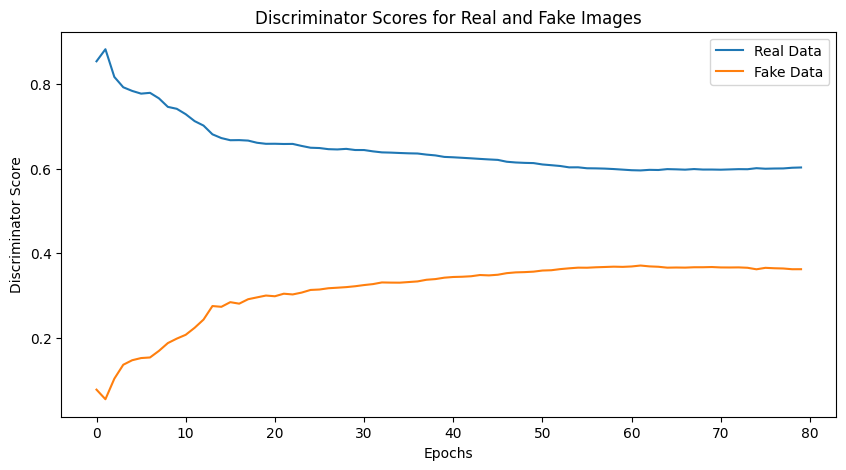

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), disc_real_scores, label="Real Data")
plt.plot(range(epochs), disc_fake_scores, label="Fake Data")
plt.xlabel("Epochs")
plt.ylabel("Discriminator Score")
plt.title("Discriminator Scores for Real and Fake Images")
plt.legend()
plt.show()


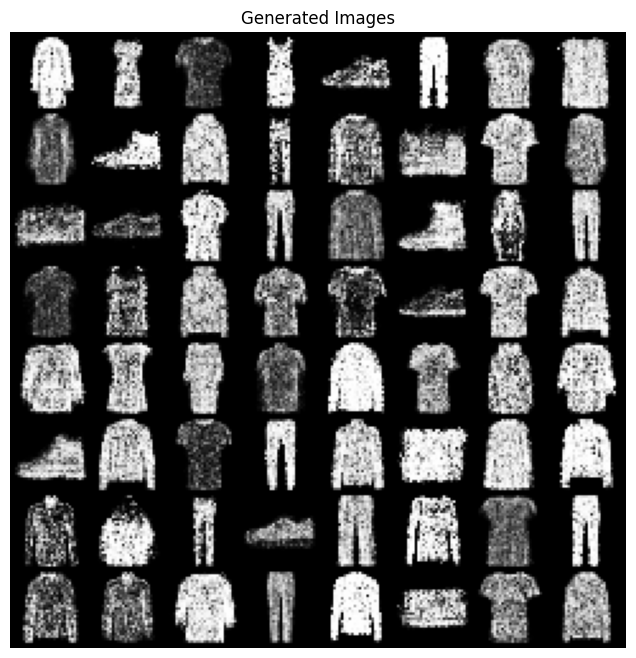

In [ ]:
# Generate images from fixed latent vectors
gan.eval()
with torch.no_grad():
    fake_images = gan.generator(fixed_latents).cpu()

# Display the images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images[:64], padding=2, normalize=True), (1, 2, 0)))
plt.show()


In [ ]:
# initialize the model
gan = NEWGAN().to(device)
# gan = NEWGAN().to(device)

# use an optimizer to handle parameter updates
opt_discriminator = torch.optim.Adam(gan.discriminator.parameters(), lr=lr)
opt_generator = torch.optim.Adam(gan.generator.parameters(), lr=lr)

################################################################################
# ...YOUR TRAINING CODE HERE: NEWGAN
################################################################################

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

# Initialize the model (Change between MLPGAN() and NEWGAN() to test both)
gan = NEWGAN().to(device)

# Initialize optimizers
opt_discriminator = optim.Adam(gan.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_generator = optim.Adam(gan.generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Lists to track discriminator scores
disc_real_scores = []
disc_fake_scores = []

# Training loop
for epoch in range(epochs):
    real_score_avg = 0
    fake_score_avg = 0
    num_batches = 0

    for real_images, _ in data:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Generate fake images
        noise = torch.randn(batch_size, latent_size, device=device)
        fake_images = gan.generator(noise)

        # Labels for real and fake images
        labels_real = torch.full((batch_size, 1), label_real, device=device)
        labels_fake = torch.full((batch_size, 1), label_fake, device=device)

        # Train Discriminator
        opt_discriminator.zero_grad()
        real_preds = gan.discriminator(real_images)
        real_loss = loss(real_preds, labels_real)

        fake_preds = gan.discriminator(fake_images.detach())  # Detach to avoid generator updates
        fake_loss = loss(fake_preds, labels_fake)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        opt_discriminator.step()

        # Train Generator
        opt_generator.zero_grad()
        fake_preds = gan.discriminator(fake_images)  # Recalculate since weights changed
        g_loss = loss(fake_preds, labels_real)  # Want fake to be classified as real
        g_loss.backward()
        opt_generator.step()

        # Store average discriminator scores for tracking
        real_score_avg += real_preds.mean().item()
        fake_score_avg += fake_preds.mean().item()
        num_batches += 1

    disc_real_scores.append(real_score_avg / num_batches)
    disc_fake_scores.append(fake_score_avg / num_batches)

    print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# Store results
torch.save(gan.state_dict(), "gan_trained_NEW.pth")


Epoch 1/80 - D Loss: 0.0093, G Loss: 6.2491
Epoch 2/80 - D Loss: 0.0188, G Loss: 5.3278
Epoch 3/80 - D Loss: 0.0143, G Loss: 5.1879
Epoch 4/80 - D Loss: 0.0622, G Loss: 5.1533
Epoch 5/80 - D Loss: 0.0515, G Loss: 4.2639
Epoch 6/80 - D Loss: 0.0165, G Loss: 5.6840
Epoch 7/80 - D Loss: 0.0344, G Loss: 4.9762
Epoch 8/80 - D Loss: 0.0573, G Loss: 4.4340
Epoch 9/80 - D Loss: 0.0698, G Loss: 3.9389
Epoch 10/80 - D Loss: 0.0191, G Loss: 4.9624
Epoch 11/80 - D Loss: 0.0338, G Loss: 4.7709
Epoch 12/80 - D Loss: 0.1482, G Loss: 5.6085
Epoch 13/80 - D Loss: 0.1536, G Loss: 5.4024
Epoch 14/80 - D Loss: 0.0494, G Loss: 4.6019
Epoch 15/80 - D Loss: 0.0693, G Loss: 8.4232
Epoch 16/80 - D Loss: 0.0569, G Loss: 4.2519
Epoch 17/80 - D Loss: 0.0448, G Loss: 4.2050
Epoch 18/80 - D Loss: 0.0241, G Loss: 5.7563
Epoch 19/80 - D Loss: 0.0264, G Loss: 6.0610
Epoch 20/80 - D Loss: 0.0314, G Loss: 5.8480
Epoch 21/80 - D Loss: 0.0094, G Loss: 6.5999
Epoch 22/80 - D Loss: 0.0267, G Loss: 5.8879
Epoch 23/80 - D Los

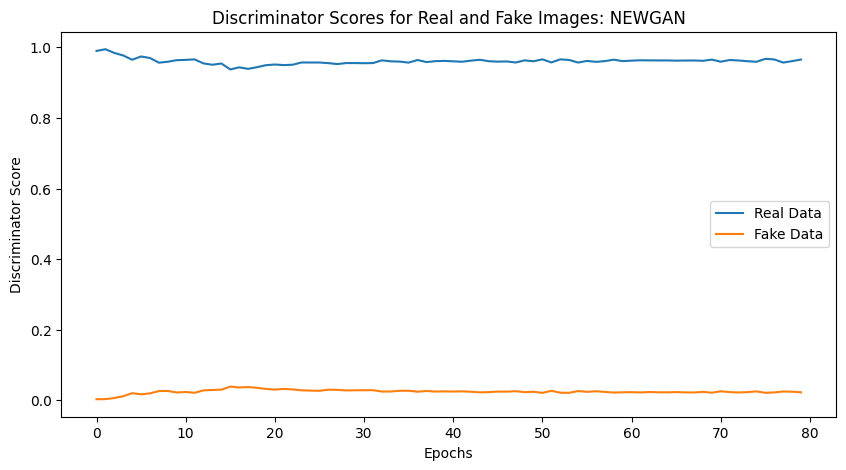

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), disc_real_scores, label="Real Data")
plt.plot(range(epochs), disc_fake_scores, label="Fake Data")
plt.xlabel("Epochs")
plt.ylabel("Discriminator Score")
plt.title("Discriminator Scores for Real and Fake Images: NEWGAN")
plt.legend()
plt.show()

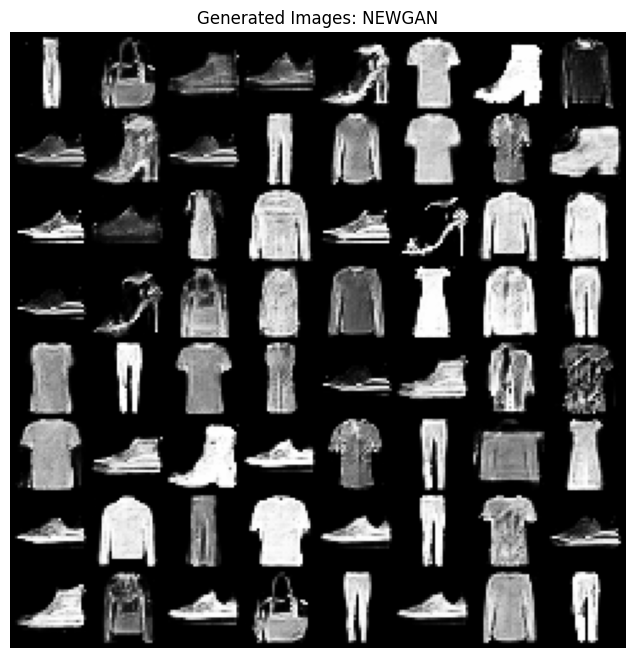

In [ ]:
# Generate images from fixed latent vectors
gan.eval()
with torch.no_grad():
    fake_images = gan.generator(fixed_latents).cpu()

# Display the images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images: NEWGAN")
plt.imshow(np.transpose(vutils.make_grid(fake_images[:64], padding=2, normalize=True), (1, 2, 0)))
plt.show()


----
## <a name="3">Question 3: Mode Collapse (four points total)</a>

GANs are notoriously difficult to train, as they involve a "competitive game" between two or more networks with multiple alternating update steps. In fact, there is a large volume of research addressing well-know GAN bugs ("_failure modes_"). In this question, we'll look at one in particular: _mode collapse_.



### __3.1__ Latent Dimension (two points)

Mode collapse occurs when a GAN learns to produce only a small set of similar outputs. We can think of these outputs as _modes_ in the data distribution, "peaks" in the likelihood function that correspond to realistic samples. To a certain extent, we want our GAN to focus on high-likelihood regions of the data space in order to produce realistic examples. However, we want our GAN to learn to sample from the entire data distribution -- not just a few points.

The figure below illustrates this phenomenon. Ideally, when we sample generator inputs from the noise ("latent") distribution $p(z)$, our GAN will produce realistic (high-likelihood) images in the data distribution $p(x)$ (third image). If we don't train our GAN well, it might fail to focus on high-likelihood regions of the data distribution and frequently output random noise (first image). If our GAN suffers from mode collapse, it will map all noise inputs to only a few high-likelihood points in the data distribution (second image).

<br/>
<center>
<img width="500px" src="https://drive.google.com/uc?export=view&id=1wxKhmfEP6QlUhsdQ7IClHrRvjm-LkVWt"/>
</center>
<br/>

Mode collapse can occur for a variety of reasons, especially in large and complex networks. Given the simplicity of our GAN architecture, we'll start with a simple example. __Train a `NEWGAN` model with a generator input dimension (`latent_size`) of 1 on FashionMNIST for 80 epochs (you will have to modify your training code so that generator inputs have size 1). Include an image of a batch of generated images below. Explain how this modification of the GAN architecture is (or isn't) reflected in your results.__

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR IMAGE HERE)</div>
</center>

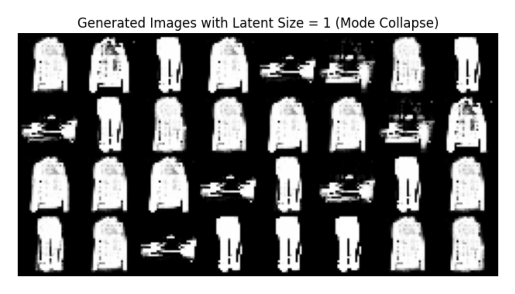

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR EXPLANATION HERE)</div>
</center>

* Looking at the result, we see a lot of repeated structures in the generated images that could indicate mode collapse.
* Even though FashionMNIST has only ten categories, we can see that the generator is producing only a very limited subset of those categories.  
* With a latent size of 1, the generator receives only one number per image, which means it lacks the ability to explore different variations. A higher latent size (e.g., 64) provides more variation, allowing the generator to create more diverse outputs.  

In [ ]:
class MLPGenerator(torch.nn.Module):
    def __init__(self, latent_size: int = 1):  # Set latent size to 1
        """Construct a simple MLP generator"""
        super().__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(latent_size, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 784),
            torch.nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor):
        n_batch = x.shape[0]
        return self.net(x).reshape(n_batch, 1, 28, 28)


In [ ]:
# Set latent size to 1
latent_size = 1

# Initialize the NEWGAN model
gan = NEWGAN(latent_size).to(device)

# Optimizers
opt_discriminator = torch.optim.Adam(gan.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_generator = torch.optim.Adam(gan.generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop
disc_real_scores = []
disc_fake_scores = []

for epoch in range(epochs):
    real_score_avg = 0
    fake_score_avg = 0
    num_batches = 0

    for real_images, _ in data:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Generate fake images using a latent vector of size 1
        noise = torch.randn(batch_size, latent_size, device=device)
        fake_images = gan.generator(noise)

        # Labels
        labels_real = torch.full((batch_size, 1), label_real, device=device)
        labels_fake = torch.full((batch_size, 1), label_fake, device=device)

        # Train Discriminator
        opt_discriminator.zero_grad()
        real_preds = gan.discriminator(real_images)
        real_loss = loss(real_preds, labels_real)

        fake_preds = gan.discriminator(fake_images.detach())
        fake_loss = loss(fake_preds, labels_fake)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        opt_discriminator.step()

        # Train Generator
        opt_generator.zero_grad()
        fake_preds = gan.discriminator(fake_images)
        g_loss = loss(fake_preds, labels_real)
        g_loss.backward()
        opt_generator.step()

        # Store discriminator scores
        real_score_avg += real_preds.mean().item()
        fake_score_avg += fake_preds.mean().item()
        num_batches += 1

    disc_real_scores.append(real_score_avg / num_batches)
    disc_fake_scores.append(fake_score_avg / num_batches)

    print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# Save model
torch.save(gan.state_dict(), "gan_mode_collapse.pth")


Epoch 1/80 - D Loss: 0.0058, G Loss: 6.2027
Epoch 2/80 - D Loss: 0.0058, G Loss: 6.4382
Epoch 3/80 - D Loss: 0.0288, G Loss: 4.7036
Epoch 4/80 - D Loss: 0.0127, G Loss: 5.2695
Epoch 5/80 - D Loss: 0.0059, G Loss: 6.9343
Epoch 6/80 - D Loss: 0.0090, G Loss: 6.9328
Epoch 7/80 - D Loss: 0.4072, G Loss: 9.0225
Epoch 8/80 - D Loss: 0.0036, G Loss: 6.3782
Epoch 9/80 - D Loss: 0.0099, G Loss: 7.2926
Epoch 10/80 - D Loss: 0.0285, G Loss: 5.2479
Epoch 11/80 - D Loss: 0.0316, G Loss: 4.4326
Epoch 12/80 - D Loss: 0.0142, G Loss: 5.4964
Epoch 13/80 - D Loss: 0.0017, G Loss: 8.9378
Epoch 14/80 - D Loss: 0.0250, G Loss: 5.4450
Epoch 15/80 - D Loss: 0.0054, G Loss: 8.6298
Epoch 16/80 - D Loss: 0.0007, G Loss: 8.0580
Epoch 17/80 - D Loss: 0.0820, G Loss: 6.8087
Epoch 18/80 - D Loss: 0.0189, G Loss: 5.0924
Epoch 19/80 - D Loss: 0.0586, G Loss: 4.6288
Epoch 20/80 - D Loss: 0.0204, G Loss: 8.0447
Epoch 21/80 - D Loss: 0.0017, G Loss: 7.1096
Epoch 22/80 - D Loss: 0.0006, G Loss: 7.7806
Epoch 23/80 - D Los

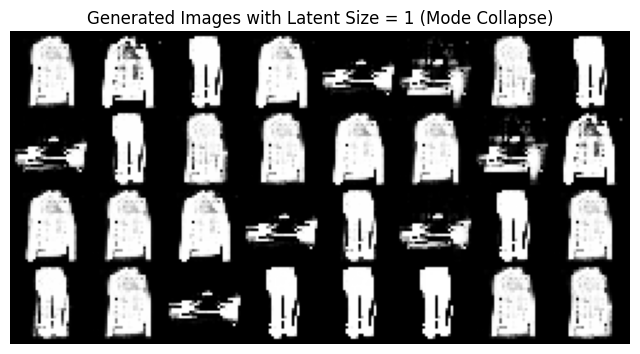

In [ ]:
# Generate images from fixed latent vectors
gan.eval()
with torch.no_grad():
    fixed_noise = torch.randn(batch_size, latent_size, device=device)  # Only one latent dimension
    fake_images = gan.generator(fixed_noise).cpu()

# Display the generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images with Latent Size = 1 (Mode Collapse)")
plt.imshow(np.transpose(vutils.make_grid(fake_images[:64], padding=2, normalize=True), (1, 2, 0)))
plt.show()


### __3.2__ Update Schedule (two points)

In some situations, it is necessary to update the generator and discriminator networks on different schedules (i.e. not just in alternating turns every batch). However, a poorly-chosen update schedule may lead to mode collapse.

__Train a `NEWGAN` model with `latent_size`=64 for 80 epochs, but modify your training code to only update the discriminator every *ten* batches. Include both a discriminator scores plot and a batch of generated images below. Finally, explain why your change to the GAN's training schedule did or did not cause a notable change in its output (compared to the original `NEWGAN`).__ _Hint: you may want to look at how your generated images evolve over time._

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR PLOT and EXAMPLE HERE)</div>
</center>

***Generated Images with Delayed Discriminator Updates***

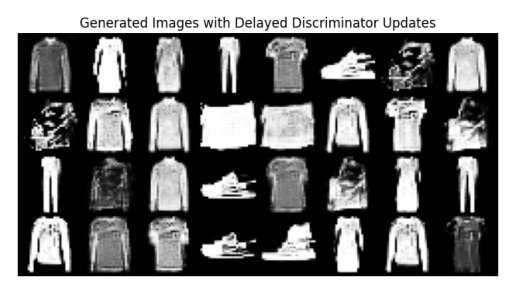

***Discriminator Scores with Delayed Updates***

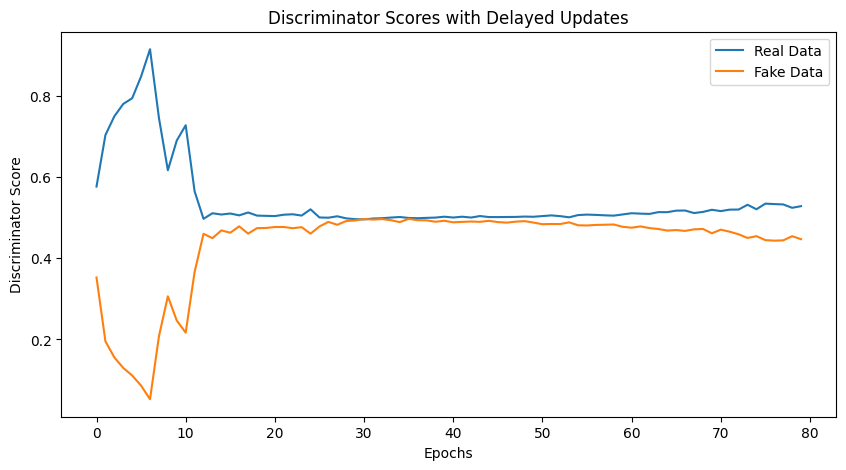

***Generated Images with Delayed Discriminator Updates***

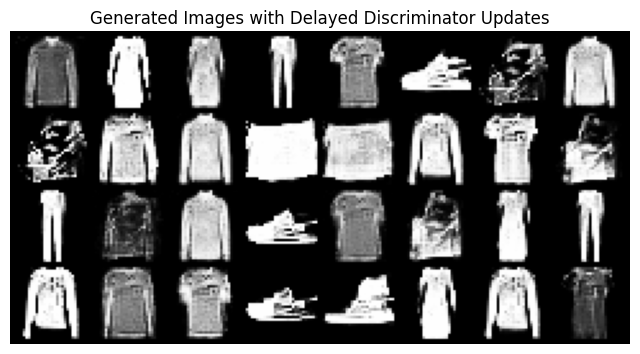

***Generated Images Every 10 Epoch***

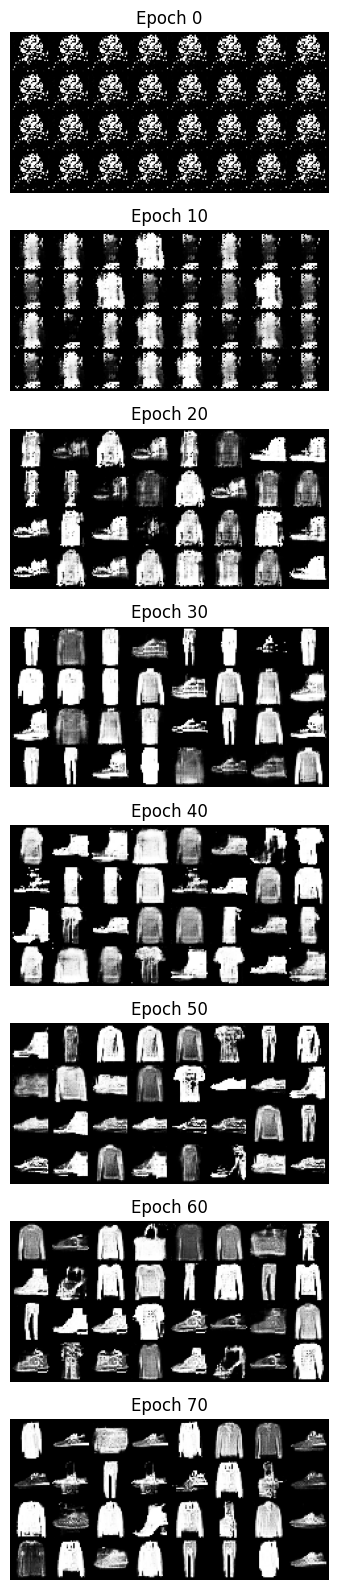

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR EXPLANATIONS HERE)</div>
</center>


- Here, we update the Generator every batch and the Discriminator every 10 batches. This means the Discriminator is updated less frequently than the Generator. Also, we use latent_size = 64.  
- As a result, the Discriminator is weaker compared to the Generator, which could allow the Generator to exploit the Discriminator.  
- Looking at the generated images, there is still some diversity, indicating that mode collapse is not too severe.  
- Examining the Discriminator Score Plot, the results appear poor. A good Discriminator Score Plot should show a clear distinction between real and fake data. However, our results suggest that real and fake data are almost entangled. Specifically, the gap between real and fake scores becomes small (~0.1 difference), particularly in the middle, indicating that the Discriminator is no longer effectively distinguishing between real and fake data. (This could suggest mode collapse, although the generated images still exhibit some diversity.)  
- Looking at the evolution of generated images over epochs, we see that the images continually improve and do not show signs of becoming too similar. Additionally, the images become sharper as the epochs progress.  

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

# Set latent size to 64
latent_size = 64

# Initialize NEWGAN model
gan = NEWGAN(latent_size).to(device)

# Optimizers
opt_discriminator = optim.Adam(gan.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_generator = optim.Adam(gan.generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop
disc_real_scores = []
disc_fake_scores = []

for epoch in range(epochs):
    real_score_avg = 0
    fake_score_avg = 0
    num_batches = 0

    for batch_idx, (real_images, _) in enumerate(data):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Generate fake images using latent vectors
        noise = torch.randn(batch_size, latent_size, device=device)
        fake_images = gan.generator(noise)

        # Labels
        labels_real = torch.full((batch_size, 1), label_real, device=device)
        labels_fake = torch.full((batch_size, 1), label_fake, device=device)

        ### Train Discriminator (Only every 10 batches) ###
        if batch_idx % 10 == 0:
            opt_discriminator.zero_grad()
            real_preds = gan.discriminator(real_images)
            real_loss = loss(real_preds, labels_real)

            fake_preds = gan.discriminator(fake_images.detach())
            fake_loss = loss(fake_preds, labels_fake)

            d_loss = real_loss + fake_loss
            d_loss.backward()
            opt_discriminator.step()

        # Train Generator (Every batch)
        opt_generator.zero_grad()
        fake_preds = gan.discriminator(fake_images)  # Recalculate since weights may have changed
        g_loss = loss(fake_preds, labels_real)  # Want fake to be classified as real
        g_loss.backward()
        opt_generator.step()

        # Store discriminator scores
        real_score_avg += real_preds.mean().item()
        fake_score_avg += fake_preds.mean().item()
        num_batches += 1

    disc_real_scores.append(real_score_avg / num_batches)
    disc_fake_scores.append(fake_score_avg / num_batches)

    print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# Save trained model
torch.save(gan.state_dict(), "gan_delayed_disc_update.pth")


Epoch 1/80 - D Loss: 1.0568, G Loss: 1.2680
Epoch 2/80 - D Loss: 0.7287, G Loss: 1.4451
Epoch 3/80 - D Loss: 0.6312, G Loss: 1.4921
Epoch 4/80 - D Loss: 0.1687, G Loss: 2.5303
Epoch 5/80 - D Loss: 0.5958, G Loss: 2.0334
Epoch 6/80 - D Loss: 0.3265, G Loss: 2.3274
Epoch 7/80 - D Loss: 0.0872, G Loss: 2.8464
Epoch 8/80 - D Loss: 1.2176, G Loss: 0.9532
Epoch 9/80 - D Loss: 0.9813, G Loss: 0.9151
Epoch 10/80 - D Loss: 0.9716, G Loss: 1.3052
Epoch 11/80 - D Loss: 0.2830, G Loss: 2.3073
Epoch 12/80 - D Loss: 0.2644, G Loss: 3.2332
Epoch 13/80 - D Loss: 0.3287, G Loss: 4.2634
Epoch 14/80 - D Loss: 2.2636, G Loss: 0.2614
Epoch 15/80 - D Loss: 0.8576, G Loss: 0.9223
Epoch 16/80 - D Loss: 0.9883, G Loss: 1.6470
Epoch 17/80 - D Loss: 1.4565, G Loss: 0.7227
Epoch 18/80 - D Loss: 1.3330, G Loss: 0.7783
Epoch 19/80 - D Loss: 1.2058, G Loss: 0.8312
Epoch 20/80 - D Loss: 1.1827, G Loss: 0.7907
Epoch 21/80 - D Loss: 1.3855, G Loss: 0.6828
Epoch 22/80 - D Loss: 1.4496, G Loss: 0.6366
Epoch 23/80 - D Los

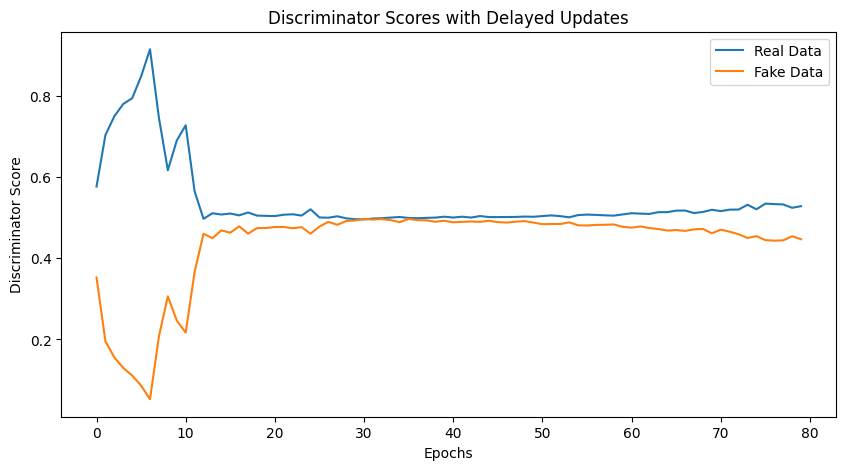

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), disc_real_scores, label="Real Data")
plt.plot(range(epochs), disc_fake_scores, label="Fake Data")
plt.xlabel("Epochs")
plt.ylabel("Discriminator Score")
plt.title("Discriminator Scores with Delayed Updates")
plt.legend()
plt.show()


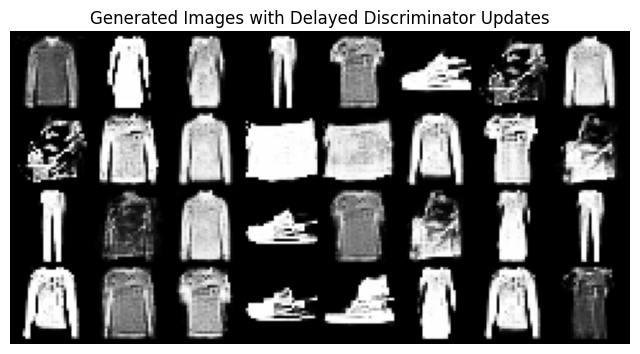

In [ ]:
# Generate images from fixed latent vectors
gan.eval()
with torch.no_grad():
    fixed_noise = torch.randn(batch_size, latent_size, device=device)
    fake_images = gan.generator(fixed_noise).cpu()

# Display the generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images with Delayed Discriminator Updates")
plt.imshow(np.transpose(vutils.make_grid(fake_images[:64], padding=2, normalize=True), (1, 2, 0)))
plt.show()


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
import os

# Set latent size to 64
latent_size = 64

# Initialize NEWGAN model
gan = NEWGAN(latent_size).to(device)

# Optimizers
opt_discriminator = optim.Adam(gan.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_generator = optim.Adam(gan.generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Create folder to store generated images over time
os.makedirs("generated_images", exist_ok=True)

# Training Loop
disc_real_scores = []
disc_fake_scores = []

for epoch in range(epochs):
    real_score_avg = 0
    fake_score_avg = 0
    num_batches = 0

    for batch_idx, (real_images, _) in enumerate(data):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Generate fake images using latent vectors
        noise = torch.randn(batch_size, latent_size, device=device)
        fake_images = gan.generator(noise)

        # Labels
        labels_real = torch.full((batch_size, 1), label_real, device=device)
        labels_fake = torch.full((batch_size, 1), label_fake, device=device)

        ### Train Discriminator (Only Every 10 Batches) ###
        if batch_idx % 10 == 0:
            opt_discriminator.zero_grad()
            real_preds = gan.discriminator(real_images)
            real_loss = loss(real_preds, labels_real)

            fake_preds = gan.discriminator(fake_images.detach())
            fake_loss = loss(fake_preds, labels_fake)

            d_loss = real_loss + fake_loss
            d_loss.backward()
            opt_discriminator.step()

        # Train Generator (Every Batch)
        opt_generator.zero_grad()
        fake_preds = gan.discriminator(fake_images)  # Recalculate since weights may have changed
        g_loss = loss(fake_preds, labels_real)  # Want fake to be classified as real
        g_loss.backward()
        opt_generator.step()

        # Store discriminator scores
        real_score_avg += real_preds.mean().item()
        fake_score_avg += fake_preds.mean().item()
        num_batches += 1

    disc_real_scores.append(real_score_avg / num_batches)
    disc_fake_scores.append(fake_score_avg / num_batches)

    print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # Save generated images every 10 epochs for tracking evolution
    if epoch % 10 == 0:
        with torch.no_grad():
            fake_images = gan.generator(torch.randn(batch_size, latent_size, device=device)).cpu()
        vutils.save_image(fake_images[:64], f"generated_images/epoch_{epoch}.png", normalize=True)

# Save trained model
torch.save(gan.state_dict(), "gan_delayed_disc_update.pth")


Epoch 1/80 - D Loss: 1.0568, G Loss: 1.2680
Epoch 2/80 - D Loss: 0.6568, G Loss: 1.3816
Epoch 3/80 - D Loss: 0.4238, G Loss: 1.7897
Epoch 4/80 - D Loss: 0.2745, G Loss: 2.3355
Epoch 5/80 - D Loss: 0.2349, G Loss: 2.5737
Epoch 6/80 - D Loss: 0.5388, G Loss: 2.2418
Epoch 7/80 - D Loss: 0.1979, G Loss: 2.7264
Epoch 8/80 - D Loss: 0.4588, G Loss: 1.6837
Epoch 9/80 - D Loss: 1.0789, G Loss: 1.1108
Epoch 10/80 - D Loss: 1.2307, G Loss: 1.0398
Epoch 11/80 - D Loss: 1.4990, G Loss: 0.7208
Epoch 12/80 - D Loss: 0.8851, G Loss: 1.8158
Epoch 13/80 - D Loss: 0.8112, G Loss: 1.1903
Epoch 14/80 - D Loss: 0.1160, G Loss: 2.6007
Epoch 15/80 - D Loss: 0.2486, G Loss: 4.0224
Epoch 16/80 - D Loss: 0.1310, G Loss: 3.0055
Epoch 17/80 - D Loss: 0.8720, G Loss: 0.9113
Epoch 18/80 - D Loss: 0.5667, G Loss: 1.4094
Epoch 19/80 - D Loss: 0.6221, G Loss: 1.1420
Epoch 20/80 - D Loss: 0.5304, G Loss: 1.3205
Epoch 21/80 - D Loss: 0.8574, G Loss: 1.3827
Epoch 22/80 - D Loss: 0.5602, G Loss: 1.7572
Epoch 23/80 - D Los

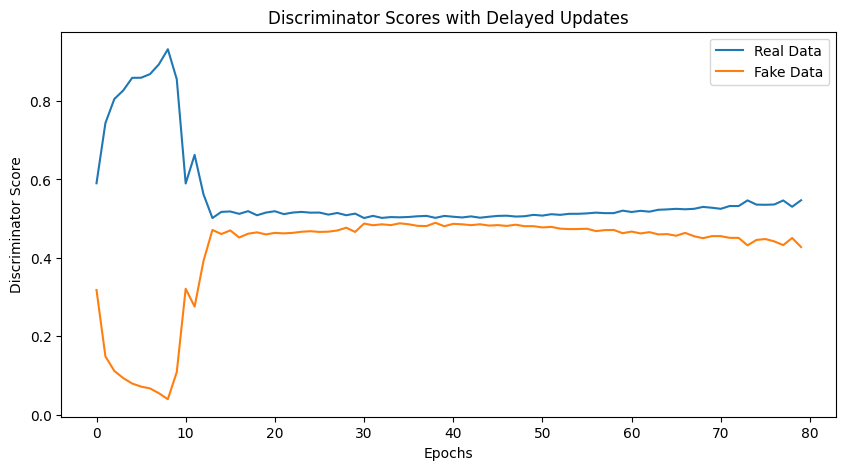

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), disc_real_scores, label="Real Data")
plt.plot(range(epochs), disc_fake_scores, label="Fake Data")
plt.xlabel("Epochs")
plt.ylabel("Discriminator Score")
plt.title("Discriminator Scores with Delayed Updates")
plt.legend()
plt.show()


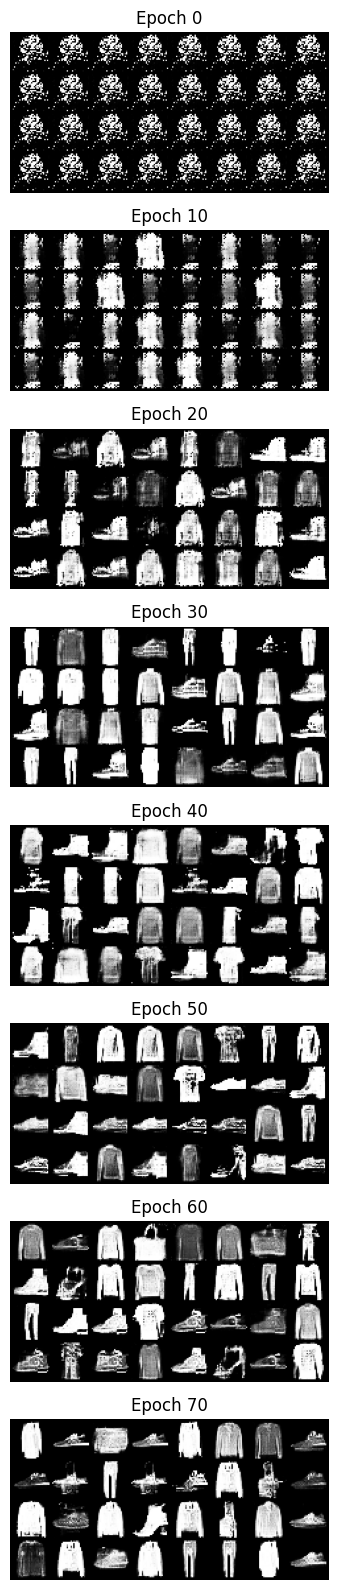

In [ ]:
import glob
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved generated images over epochs
image_paths = sorted(glob.glob("generated_images/*.png"))

# Adjust figure size to match the batch image display (8, 8)
fig, axes = plt.subplots(len(image_paths), 1, figsize=(8, 8 * len(image_paths) // 4))

for i, img_path in enumerate(image_paths):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Epoch {i * 10}")

plt.tight_layout()
plt.show()


----
## <a name="4">Question 4 (four points total)</a>

GANs generate by mapping latent noise vectors to synthetic instances. In [notebook 6](https://github.com/interactiveaudiolab/course-deep-learning/blob/main/notebooks/notebook_6_gan.ipynb), we saw that we could perform an "inverse" mapping from a real image to a corresponding latent vector using aversarial-example-like optimization. This lets us do cool things, like smoothly interpolating between images.

### __4.1__ Finding Latents (two points)

__Find which numeric labels correspond to the FashionMNIST classes for "sneaker" and "handbag." Select one instance of each class. Then, using your "best" trained `NEWGAN` model from the questions above and the method outlined in notebook 6, compute a latent vector corresponding to each instance. Finally, pass each latent vector through the generator network to obtain a "reconstruction" of each instance.__ _Hint: you may want to implement a learning rate and adjust the number of iterations for your reconstructions._

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR TWO ORIGINAL IMAGES AND YOUR TWO RECONSTRUCTED IMAGES HERE)</div>
</center>

***RECONSTRUCTED IMAGES Using NEWGAN from Q3***

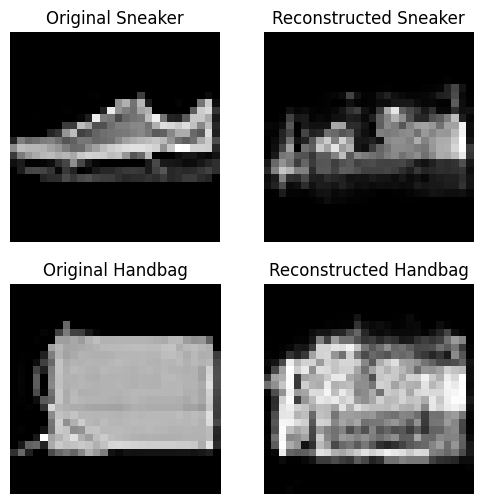

***RECONSTRUCTED IMAGES Using method outlined in notebook 6***

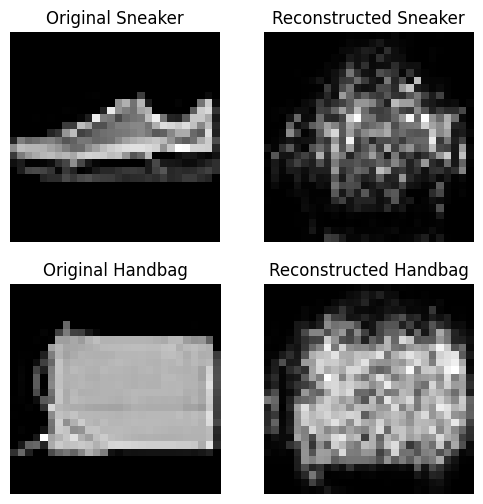


* I tried adjusting the iterations and learning rates in the `find_latent_vector` function, but it doesn’t seem to work any better (for both models).  
* It could be that the generator is not well-trained, or the latent vector optimization is poor.

<ipython-input-71-0ad00e2b75c2>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("gan_delayed_disc_update.pth", map_location=device)


Model loaded successfully!


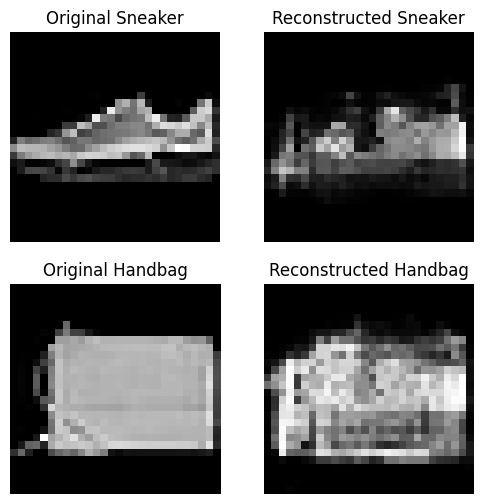

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Load FashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Get one instance of "sneaker" (7) and "handbag" (8)
sneaker_idx = next(i for i, (img, label) in enumerate(dataset) if label == 7)
handbag_idx = next(i for i, (img, label) in enumerate(dataset) if label == 8)

sneaker_img, _ = dataset[sneaker_idx]
handbag_img, _ = dataset[handbag_idx]

# Find the latent vectors z fed into the generator
def find_latent_vector(generator, real_img, latent_dim=50, lr=0.0005, iterations=500):
    real_img = real_img.unsqueeze(0)  
    real_img = real_img.to(next(generator.parameters()).device) 

    z = torch.randn(1, latent_dim, device=real_img.device, requires_grad=True) # gradient tracking wrt z
    optimizer = optim.Adam([z], lr=lr)

    loss_fn = nn.MSELoss()

    for _ in range(iterations):
        optimizer.zero_grad()
        generated_img = generator(z) # Generate image from latent vector z
        loss = loss_fn(generated_img, real_img) # Compute loss between reconstructed and real image
        loss.backward() # Compute gradients wrt z
        optimizer.step()

    return z

latent_dim = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the data trained in q3 from "gan_delayed_disc_update.pth"
checkpoint = torch.load("gan_delayed_disc_update.pth", map_location=device) # contains weights of generator and discriminator

# Extract only the generator's weights
generator_state_dict = {k.replace("generator.", ""): v for k, v in checkpoint.items() if k.startswith("generator.")}

# Initialize model and load weights
latent_dim = 64 
your_NEWGAN_generator = MLPGenerator(latent_dim).to(device)
your_NEWGAN_generator.load_state_dict(generator_state_dict)
your_NEWGAN_generator.eval()


print("Model loaded successfully!")

# Compute latent vectors
sneaker_latent = find_latent_vector(your_NEWGAN_generator, sneaker_img, latent_dim=latent_dim)
handbag_latent = find_latent_vector(your_NEWGAN_generator, handbag_img, latent_dim=latent_dim)

# Generate reconstructions
sneaker_recon = your_NEWGAN_generator(sneaker_latent).detach().cpu().squeeze(0)
handbag_recon = your_NEWGAN_generator(handbag_latent).detach().cpu().squeeze(0)

# Plot original vs. reconstructed
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

axs[0, 0].imshow(sneaker_img.squeeze(), cmap='gray')
axs[0, 0].set_title("Original Sneaker")
axs[0, 1].imshow(sneaker_recon.squeeze(), cmap='gray')
axs[0, 1].set_title("Reconstructed Sneaker")

axs[1, 0].imshow(handbag_img.squeeze(), cmap='gray')
axs[1, 0].set_title("Original Handbag")
axs[1, 1].imshow(handbag_recon.squeeze(), cmap='gray')
axs[1, 1].set_title("Reconstructed Handbag")

for ax in axs.flat:
    ax.axis('off')

plt.show()


In [ ]:
### train model similar to notebook 6
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define MLP Generator
class MLPGenerator(nn.Module):
    def __init__(self, number_of_hidden_layers, input_size, hidden_size, output_size, activation):
        super().__init__()

        assert number_of_hidden_layers >= 0, "Generator number_of_hidden_layers must be at least 0"

        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [output_size]
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(nn.Linear(dims_in[i], dims_out[i]))
            if i < number_of_hidden_layers:
                layers.append(activation)

        layers.append(nn.Sigmoid())  # To constrain outputs to [0,1]

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


# Define MLP Discriminator
class MLPDiscriminator(nn.Module):
    def __init__(self, number_of_hidden_layers, input_size, hidden_size, activation):
        super().__init__()

        assert number_of_hidden_layers >= 0, "Discriminator number_of_hidden_layers must be at least 0"

        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [1]
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(nn.Linear(dims_in[i], dims_out[i]))
            if i < number_of_hidden_layers:
                layers.append(activation)

        layers.append(nn.Sigmoid()) 

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


# Define MLPGAN Class
class MLPGAN(nn.Module):
    def __init__(self, number_of_hidden_layers, latent_size, hidden_size, output_size,
                 activation_generator=nn.ReLU(), activation_discriminator=nn.LeakyReLU(0.2)):
        super().__init__()

        self.generator = MLPGenerator(
            number_of_hidden_layers=number_of_hidden_layers,
            input_size=latent_size,
            hidden_size=hidden_size,
            output_size=output_size,
            activation=activation_generator
        )

        self.discriminator = MLPDiscriminator(
            number_of_hidden_layers=number_of_hidden_layers,
            input_size=output_size,
            hidden_size=hidden_size,
            activation=activation_discriminator
        )


In [74]:
# Hyperparameters
image_size = 28
batch_size = 64
latent_size = 64
hidden_size = 256
number_of_hidden_layers = 2
lr = 0.0002
epochs = 80

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
mnist = DataLoader(datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform),
                   batch_size=batch_size, shuffle=True)

# Initialize the model
gan = MLPGAN(number_of_hidden_layers, latent_size, hidden_size, output_size=image_size * image_size).to(device)

# Optimizers
opt_discriminator = optim.Adam(gan.discriminator.parameters(), lr=lr)
opt_generator = optim.Adam(gan.generator.parameters(), lr=lr)

# Loss function
loss_fn = nn.BCELoss()

# Labels for real and fake images
label_real = 1.0
label_fake = 0.0

# Training Loop
for epoch in range(epochs):
    for batch_data, _ in mnist:
        batch_size = batch_data.shape[0]
        batch_data = batch_data.to(device)

        # Train Discriminator
        gan.discriminator.zero_grad()

        # Real images
        real_labels = torch.full((batch_size, 1), label_real, device=device)
        preds_real = gan.discriminator(batch_data)
        loss_real = loss_fn(preds_real, real_labels)

        # Fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = gan.generator(z)
        fake_labels = torch.full((batch_size, 1), label_fake, device=device)
        preds_fake = gan.discriminator(fake_images.detach())
        loss_fake = loss_fn(preds_fake, fake_labels)

        loss_discriminator = loss_real + loss_fake
        loss_discriminator.backward()
        opt_discriminator.step()

        # Train Generator
        gan.generator.zero_grad()
        preds_fake = gan.discriminator(fake_images)
        loss_generator = loss_fn(preds_fake, real_labels)
        loss_generator.backward()
        opt_generator.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs} | D Loss: {loss_discriminator.item():.4f} | G Loss: {loss_generator.item():.4f}")

# Save trained model
torch.save(gan.generator.state_dict(), "mlp_gan_generator.pth")
print("Model training complete. Generator saved!")

Epoch 1/80 | D Loss: 0.1658 | G Loss: 5.7165
Epoch 11/80 | D Loss: 0.3677 | G Loss: 3.7231
Epoch 21/80 | D Loss: 0.4768 | G Loss: 2.5601
Epoch 31/80 | D Loss: 0.4732 | G Loss: 2.5055
Epoch 41/80 | D Loss: 0.7535 | G Loss: 2.1960
Epoch 51/80 | D Loss: 0.6834 | G Loss: 2.7873
Epoch 61/80 | D Loss: 0.7214 | G Loss: 2.0593
Epoch 71/80 | D Loss: 0.8844 | G Loss: 1.8095
Model training complete. Generator saved!


<ipython-input-146-9b7a3ef4b582>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  your_NEWGAN_generator.load_state_dict(torch.load("mlp_gan_generator.pth", map_location=dev

Model loaded successfully!


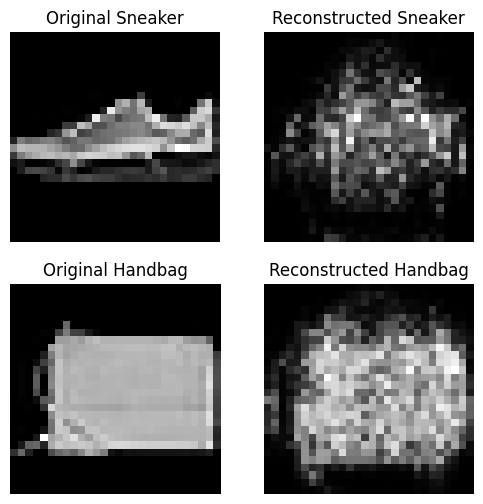

In [146]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load FashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Select one instance of "sneaker" (7) and "handbag" (8)
sneaker_idx = next(i for i, (img, label) in enumerate(dataset) if label == 7)
handbag_idx = next(i for i, (img, label) in enumerate(dataset) if label == 8)

sneaker_img, _ = dataset[sneaker_idx]
handbag_img, _ = dataset[handbag_idx]

# Move images to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sneaker_img = sneaker_img.to(device)
handbag_img = handbag_img.to(device)

# Define Generator (must match trained model)
class MLPGenerator(nn.Module):
    def __init__(self, number_of_hidden_layers, input_size, hidden_size, output_size, activation):
        super().__init__()
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [output_size]
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(nn.Linear(dims_in[i], dims_out[i]))
            if i < number_of_hidden_layers:
                layers.append(activation)
        layers.append(nn.Sigmoid())  # Constrain output to [0,1]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Load trained generator
latent_dim = 64
your_NEWGAN_generator = MLPGenerator(
    number_of_hidden_layers=2,
    input_size=latent_dim,
    hidden_size=256,
    output_size=28*28,
    activation=nn.ReLU()
).to(device)

your_NEWGAN_generator.load_state_dict(torch.load("mlp_gan_generator.pth", map_location=device))
your_NEWGAN_generator.eval()

print("Model loaded successfully!")

# Function to find latent vector that reconstructs an image
def find_latent_vector(generator, real_img, latent_dim=64, lr=0.06, iterations=1000):
    real_img = real_img.view(1, -1).to(next(generator.parameters()).device)  # Flatten & move to device

    # Initialize a random latent vector with gradients
    z = torch.randn(1, latent_dim, device=real_img.device, requires_grad=True)

    optimizer = optim.Adam([z], lr=lr)
    loss_fn = nn.MSELoss()

    for _ in range(iterations):
        optimizer.zero_grad()
        generated_img = generator(z)
        loss = loss_fn(generated_img, real_img)  # Compare with original image
        loss.backward()
        optimizer.step()

    return z

# Compute latent vectors
sneaker_latent = find_latent_vector(your_NEWGAN_generator, sneaker_img, latent_dim=latent_dim)
handbag_latent = find_latent_vector(your_NEWGAN_generator, handbag_img, latent_dim=latent_dim)

# Generate reconstructions
sneaker_recon = your_NEWGAN_generator(sneaker_latent).detach().cpu().squeeze(0).reshape(28, 28)
handbag_recon = your_NEWGAN_generator(handbag_latent).detach().cpu().squeeze(0).reshape(28, 28)

# Plot original vs. reconstructed images
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

axs[0, 0].imshow(sneaker_img.cpu().squeeze(), cmap='gray')
axs[0, 0].set_title("Original Sneaker")
axs[0, 1].imshow(sneaker_recon, cmap='gray')
axs[0, 1].set_title("Reconstructed Sneaker")

axs[1, 0].imshow(handbag_img.cpu().squeeze(), cmap='gray')
axs[1, 0].set_title("Original Handbag")
axs[1, 1].imshow(handbag_recon, cmap='gray')
axs[1, 1].set_title("Reconstructed Handbag")

for ax in axs.flat:
    ax.axis('off')

plt.show()


### __4.2__ Interpolating Between Latents (two points)

Notebook 6 describes how to visualize a smooth interpolation between latent vectors. __Do the same here, but instead of a video, save and include _four_ "intermediate" images as you interpolate between the two latent vectors you generated in question 4.1.__ If you want a "smoother" interpolation, you can simply generate more intermediate images and cherry-pick four that illustrate the progression from one instance to the other.

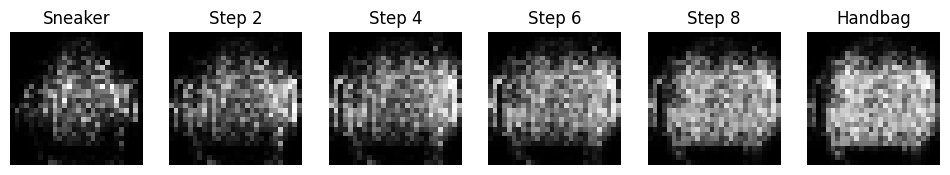

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

num_interpolations = 10

# Generate interpolated latent vectors
interpolated_latents = [
    (1 - alpha) * sneaker_latent + alpha * handbag_latent
    for alpha in np.linspace(0, 1, num_interpolations)
]

# Generate images from interpolated latents
interpolated_images = [your_NEWGAN_generator(latent).detach().cpu().squeeze(0).reshape(28, 28) for latent in interpolated_latents]

# Pick 4 images
selected_indices = [2, 4, 6, 8]
selected_images = [interpolated_images[i] for i in selected_indices]

# Plot images
fig, axs = plt.subplots(1, 6, figsize=(12, 3))  # 6 images: original sneaker, 4 intermediates, handbag

axs[0].imshow(sneaker_recon, cmap='gray')
axs[0].set_title("Sneaker")

for i, img in enumerate(selected_images):
    axs[i + 1].imshow(img, cmap='gray')
    axs[i + 1].set_title(f"Step {selected_indices[i]}")

axs[-1].imshow(handbag_recon, cmap='gray')
axs[-1].set_title("Handbag")

for ax in axs:
    ax.axis('off')

plt.show()

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR INTERPOLATED IMAGES HERE)</div>
</center>

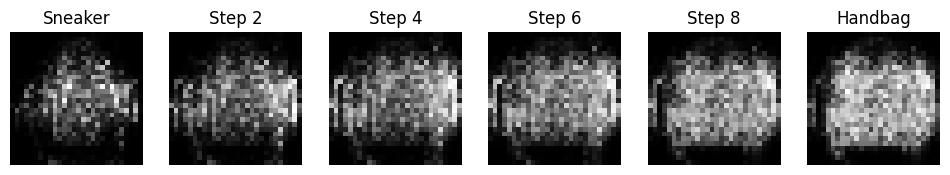

* The latent vector from the previous run is clearly not optimal, which is probably why the image is so blurry here.  
* However, we can still see the interpolation between the sneaker and the handbag.